Align forecasted and observed temperatures per region.
--

In [58]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

import hakom
from hakom.repositories.timeseries.data import TimeSeriesDataItemTimeStamp
import getpass

Authenticate with the service:

In [59]:
api_pwd = getpass.getpass()

········


In [60]:
auth_params = hakom.authorization.AuthParams(
    username = '',
    password = api_pwd,
)

service_config = hakom.service.ServiceConfig(
    base_url="",
    auth_params=auth_params,
    repository=''
)

hakom.initialize(service_config)

Check whether service is running:

In [61]:
hakom.get_config().check_health()

True

In [62]:
hakom.versioninfo.get()

{'Name': 'HAKOM WebTSM Services',
 'Description': 'Time Series Management Webservices',
 'Version': '3.9.2.1-rc+0'}

## 1. Load and plot data

Get the start and end dates of observed and forecasted temperatures: 

In [63]:
metainfo_observed = hakom.repositories.timeseries.metainfo.get('1134') # Observed temperature
metainfo_forecasted_short_term = hakom.repositories.timeseries.metainfo.get('1135') # Short-term forecast
metainfo_forecasted_long_term = hakom.repositories.timeseries.metainfo.get('1316') # Long-term forecast, based on the forecasts from different regions, [1316] Temperatura Belo Horizonte fonte GRIB 

Comment on Python client: function to load the entire time-series without passing the dates is missing

In [64]:
query_params = []
query_params.append(hakom.commons.QueryParam("id", "1134"))
query_params.append(hakom.commons.QueryParam("id", "1135"))
query_params.append(hakom.commons.QueryParam("id", "1141"))
query_params.append(hakom.commons.QueryParam("id", "1142"))
query_params.append(hakom.commons.QueryParam("id", "1133"))
query_params.append(hakom.commons.QueryParam("id", "1137"))
query_params.append(hakom.commons.QueryParam("id", "1136"))
query_params.append(hakom.commons.QueryParam("id", "1140"))
query_params.append(hakom.commons.QueryParam("id", "1315"))
query_params.append(hakom.commons.QueryParam("id", "1304"))
query_params.append(hakom.commons.QueryParam("id", "1308"))
query_params.append(hakom.commons.QueryParam("id", "1299"))
query_params.append(hakom.commons.QueryParam("from", metainfo_observed['DataPeriod']['From']))
query_params.append(hakom.commons.QueryParam("to", metainfo_forecasted_long_term['DataPeriod']['To']))


timeseries_data= hakom.repositories.timeseriescollections.data.get(query_params,hakom.errorhandling.BulkResultBehaviours.FullResult)
matrix = hakom.converters.timeseries_data_collection_matrix(timeseries_data)
 
df = pd.DataFrame(matrix)

In [65]:
df.head()

,From,Temperatura Subsistema SECO,Temperatura Subsistema SECO - Previsão ONS,Temperatura Subsistema S,Temperatura Subsistema S - Previsão ONS,Temperatura Subsistema NE,Temperatura Subsistema NE - Previsão ONS,Temperatura Subsistema N,Temperatura Subsistema N - Previsão ONS,Temperatura Subsistema SECO - Previsão GRIB,Temperatura Subsistema S - Previsão GRIB,Temperatura Subsistema NE - Previsão GRIB,Temperatura Subsistema N - Previsão GRIB
0,2017-01-01T00:00:00Z,24.889000,0.0,23.905001,0.0,27.367001,0.0,25.209999,0.0,0.0,0.0,0.0,0.0
1,2017-01-01T01:00:00Z,24.791000,0.0,22.938999,0.0,26.237000,0.0,25.080000,0.0,0.0,0.0,0.0,0.0
2,2017-01-01T02:00:00Z,24.250000,0.0,23.132999,0.0,26.219999,0.0,25.209999,0.0,0.0,0.0,0.0,0.0
3,2017-01-01T03:00:00Z,24.365000,0.0,22.650000,0.0,26.049999,0.0,25.080000,0.0,0.0,0.0,0.0,0.0
4,2017-01-01T04:00:00Z,23.674999,0.0,22.650000,0.0,25.653000,0.0,24.790001,0.0,0.0,0.0,0.0,0.0


Rename columns:

In [66]:
col_dict = {}

for col in df.columns:
    if col.__contains__('From'):
        name = col
        col_dict[col] = name
    elif col.__contains__('ONS'):
        region = col[col.find('Temperatura Subsistema')+23:col.find('-')-1]
        name = 'short_term_' + region
        col_dict[col] = name
    elif col.__contains__('GRIB'):
        region = col[col.find('Temperatura Subsistema')+23:col.find('-')-1]
        name = 'long_term_' + region
        col_dict[col] = name
    else:
        region = col[col.find('Temperatura Subsistema')+23:]
        name = 'obs_' + region
        col_dict[col] = name

In [67]:
df.rename(columns = col_dict,inplace = True)

In [68]:
df['From'] = pd.to_datetime(df['From'], format="%Y-%m-%d %H:%M:%S")

In [69]:
df.head()

,From,obs_SECO,short_term_SECO,obs_S,short_term_S,obs_NE,short_term_NE,obs_N,short_term_N,long_term_SECO,long_term_S,long_term_NE,long_term_N
0,2017-01-01 00:00:00+00:00,24.889000,0.0,23.905001,0.0,27.367001,0.0,25.209999,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 01:00:00+00:00,24.791000,0.0,22.938999,0.0,26.237000,0.0,25.080000,0.0,0.0,0.0,0.0,0.0
2,2017-01-01 02:00:00+00:00,24.250000,0.0,23.132999,0.0,26.219999,0.0,25.209999,0.0,0.0,0.0,0.0,0.0
3,2017-01-01 03:00:00+00:00,24.365000,0.0,22.650000,0.0,26.049999,0.0,25.080000,0.0,0.0,0.0,0.0,0.0
4,2017-01-01 04:00:00+00:00,23.674999,0.0,22.650000,0.0,25.653000,0.0,24.790001,0.0,0.0,0.0,0.0,0.0


a. Analyze long- and short-term forecasts
--

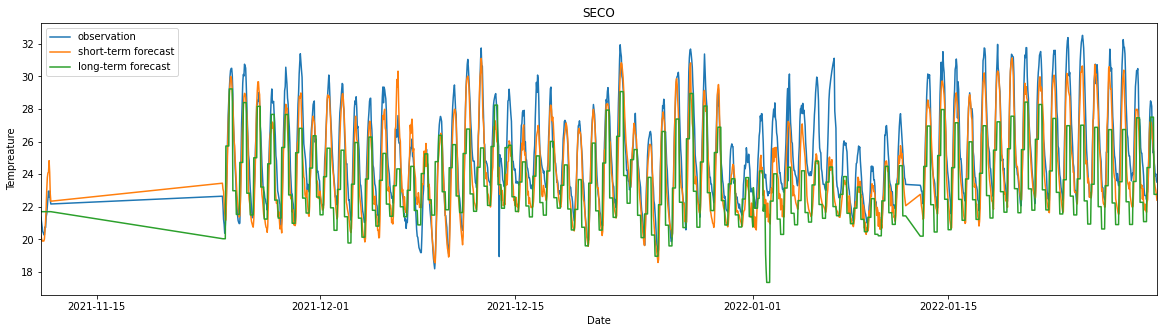

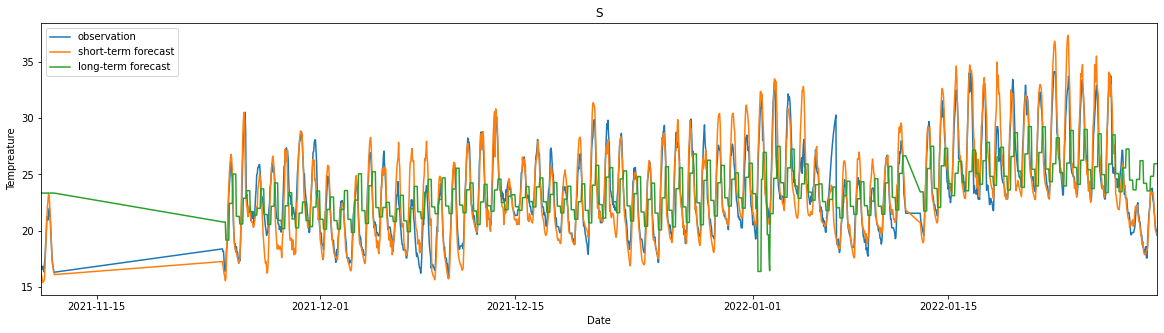

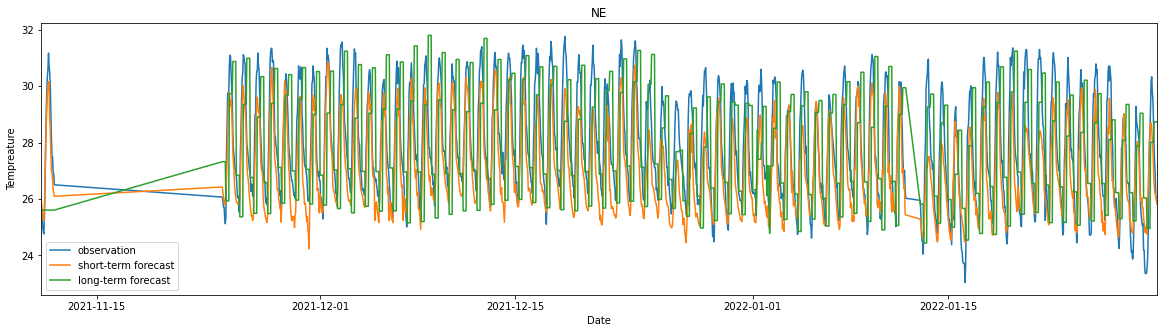

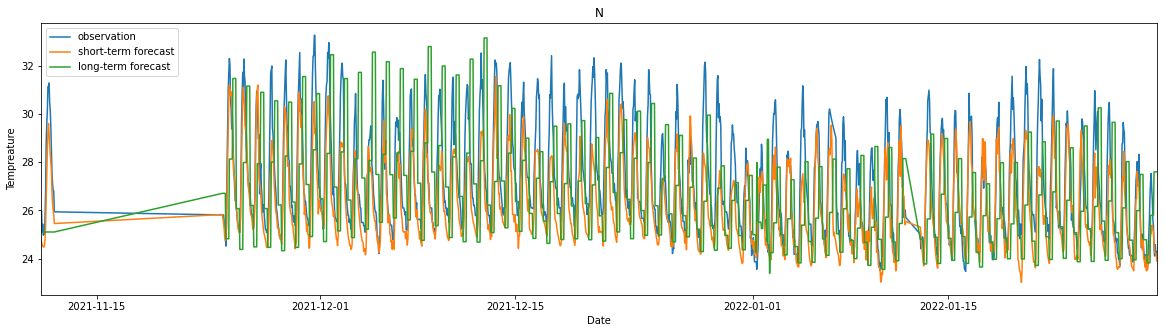

In [70]:
region = "";

for col in df.iloc[:,0:9].columns[range(1,9,2)]:
    
    region=(col[col.find("_")+1:])
    temp = df[{"From","obs_"+region,"short_term_"+region, "long_term_"+region}]

    fig, ax = plt.subplots(1,1,figsize=(20,5))
    cond = (temp["obs_"+region]!=0) & (temp["short_term_"+region]!=0) & (temp["long_term_"+region]!=0)
    # Observations
    plt.plot(temp.loc[cond]["From"],temp.loc[cond]["obs_"+region], label='observation')
    # Short-term forecast
    plt.plot(temp.loc[cond]["From"],temp.loc[cond]["short_term_"+region], label='short-term forecast')
    # Long-term forecast
    plt.plot(temp.loc[cond]["From"],temp.loc[cond]["long_term_"+region], label='long-term forecast')

    plt.xlabel('Date')
    plt.ylabel('Tempreature')
    plt.title(region)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::len(xticks) // 5]) 
    ax.tick_params(axis='x') 
    ax.margins(x=0)
    plt.legend()
    plt.show();

Display data for shorter period of time:

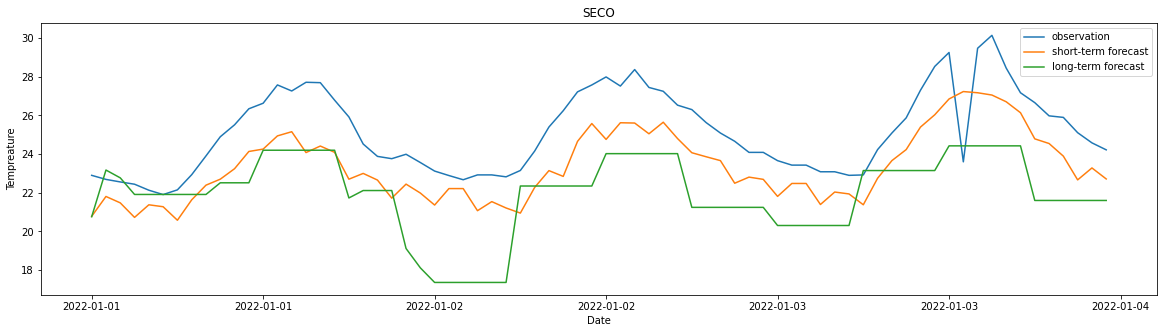

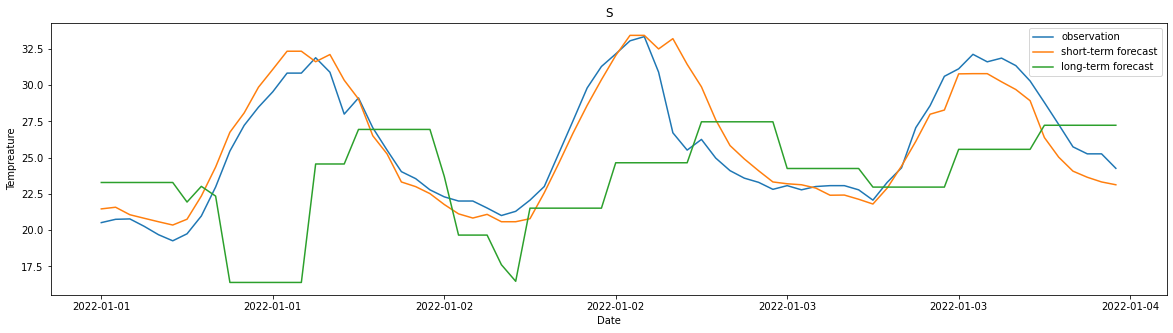

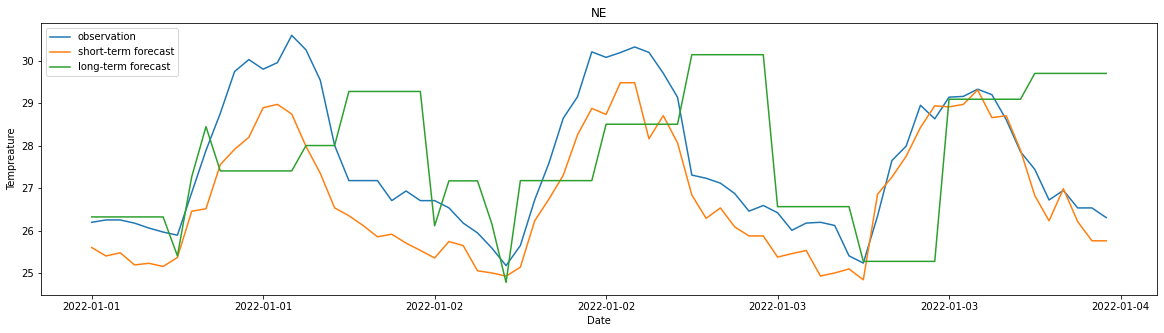

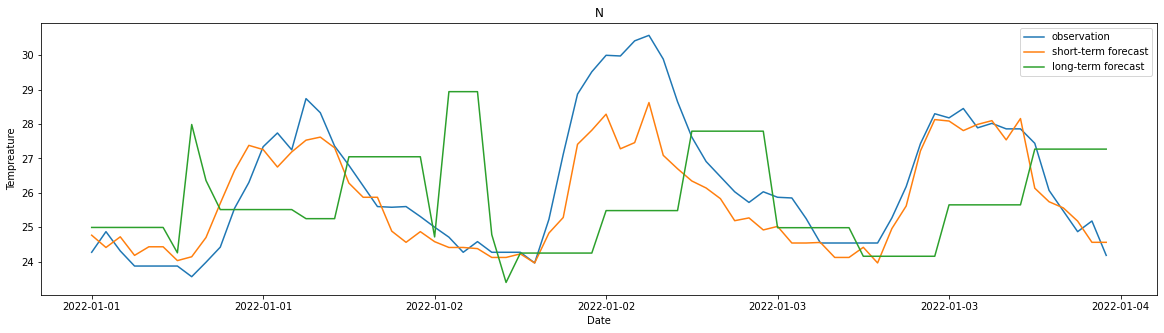

In [71]:
start = datetime.date(2022,1,1)
end = datetime.date(2022,1,3)

region = "";

for col in df.iloc[:,0:9].columns[range(1,9,2)]:
    
    region=(col[col.find("_")+1:])
    temp = df[{"From","obs_"+region,"short_term_"+region,"long_term_"+region}]

    fig, ax = plt.subplots(1,1,figsize=(20,5))
    cond1 = (temp["obs_"+region]!=0) & (temp["short_term_"+region]!=0) & (temp["long_term_"+region]!=0)
    cond2 = (temp["From"].dt.date>=start) & (temp["From"].dt.date<=end)
    # Observations
    plt.plot(temp.loc[cond1 & cond2]["From"],\
             temp.loc[cond1 & cond2]["obs_"+region], label='observation')
    # Short-term forecast
    plt.plot(temp.loc[cond1 & cond2]["From"],\
            temp.loc[cond1 & cond2]["short_term_"+region], label='short-term forecast')
    # Long-term forecast
    plt.plot(temp.loc[cond1 & cond2]["From"],\
            temp.loc[cond1 & cond2]["long_term_"+region], label='long-term forecast')

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Tempreature')
    plt.title(region)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::len(xticks) // 5]) 
    ax.tick_params(axis='x') 
    plt.legend()
    plt.show();

Shift the forecast if required:

In [72]:
d = {'reg': ['SECO','S','NE','N'], 'short_term': [0,0,0,0], 'long_term':[0,-6,-6,-6]} # lag in hours per region
steps = pd.DataFrame(data=d)

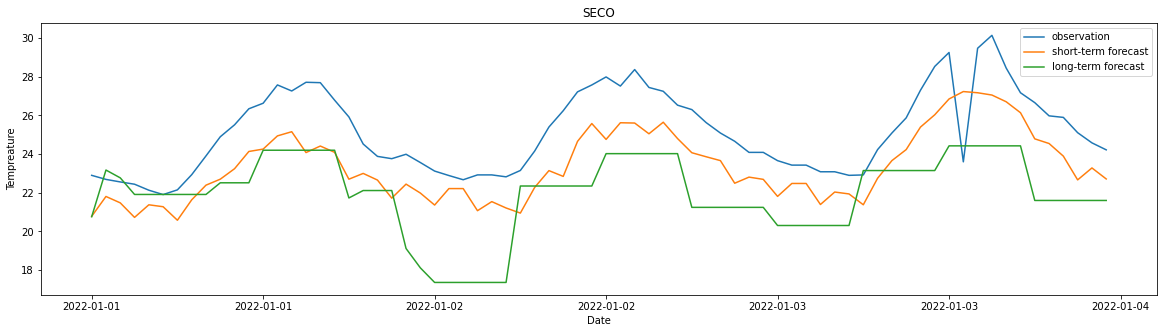

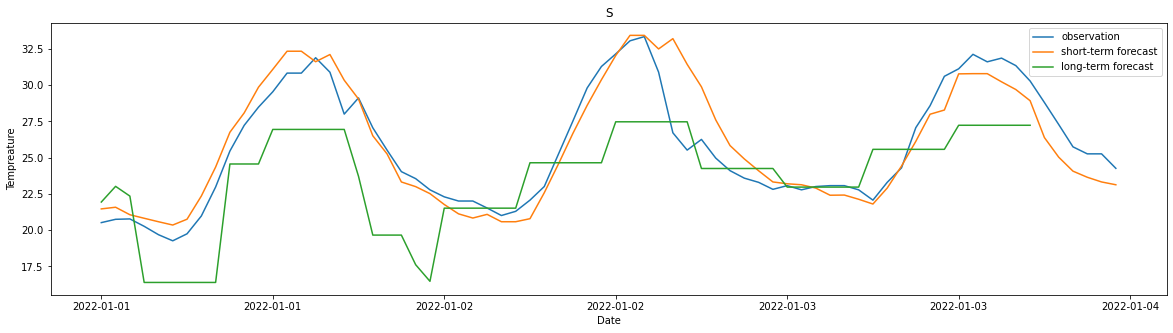

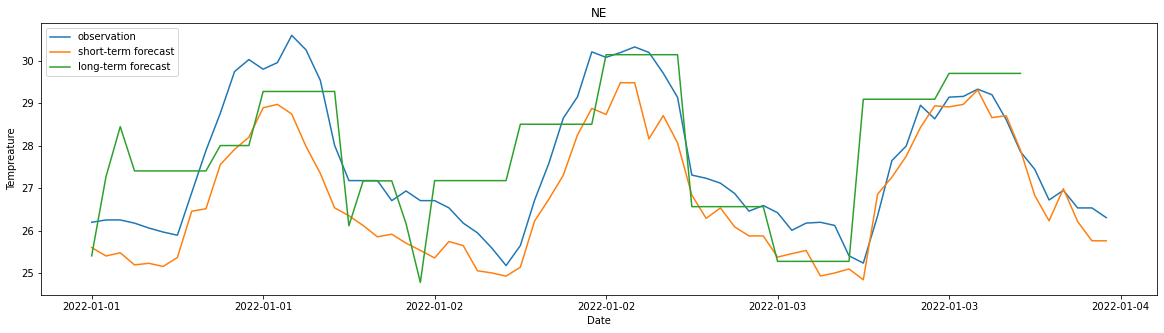

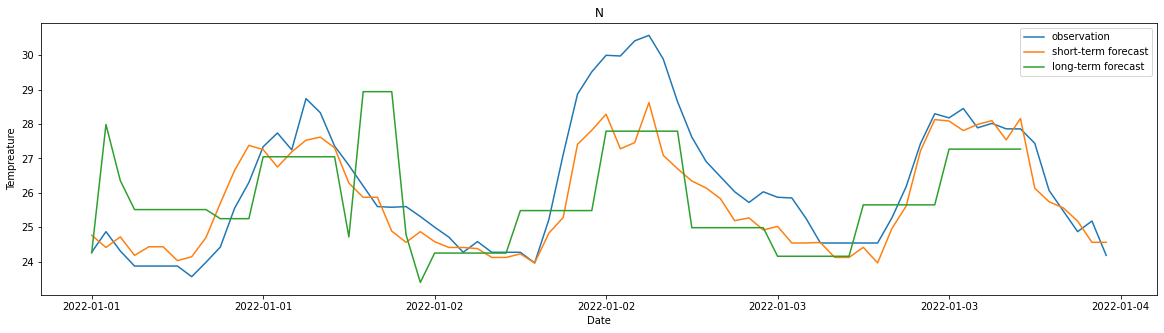

In [73]:
start = datetime.date(2022,1,1)
end = datetime.date(2022,1,3)

region = "";

for col in df.iloc[:,0:9].columns[range(1,9,2)]:
    
    region=(col[col.find("_")+1:])
    temp = df[{"From","obs_"+region,"short_term_"+region,"long_term_"+region}]
    
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    cond1 = (temp["obs_"+region]!=0) & (temp["short_term_"+region]!=0) & (temp["long_term_"+region]!=0)
    cond2 = (temp["From"].dt.date>=start) & (temp["From"].dt.date<=end)
    # Observations
    plt.plot(temp.loc[cond1 & cond2]["From"],\
             temp.loc[cond1 & cond2]["obs_"+region], label='observation')
    # Short-term forecast
    plt.plot(temp.loc[cond1 & cond2]["From"],\
            temp.loc[cond1 & cond2]["short_term_"+region].shift(steps.loc[steps.reg==region].short_term.item()), label='short-term forecast')
    # Long-term forecast
    plt.plot(temp.loc[cond1 & cond2]["From"],\
            temp.loc[cond1 & cond2]["long_term_"+region].shift(steps.loc[steps.reg==region].long_term.item()), label='long-term forecast')
        
    plt.xlabel('Date')
    plt.ylabel('Tempreature')
    plt.title(region)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::len(xticks) // 5]) 
    ax.tick_params(axis='x') 
    plt.legend()
    plt.show();

## 2. Forecast vs observed temperatures: linear model

In [74]:
shifted_df = df.copy()

In [75]:
region = "";

for col in shifted_df.iloc[:,0:9].columns[range(1,9,2)]:
    
    region=(col[col.find("_")+1:])
    
    # Shift short-term forecast
    shifted_df["short_term_shift_"+region] = shifted_df["short_term_"+region].shift(steps.loc[steps.reg==region].short_term.item())
    # Shift long-term forecast
    shifted_df["long_term_shift_"+region] = shifted_df["long_term_"+region].shift(steps.loc[steps.reg==region].long_term.item())

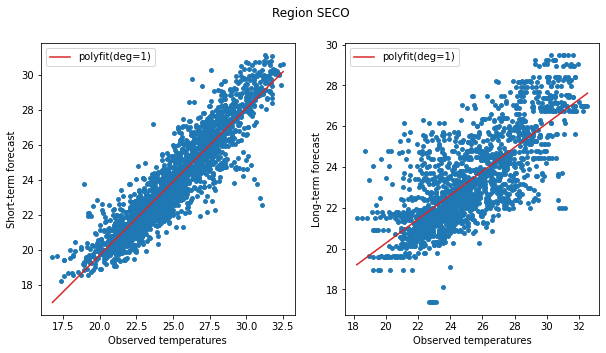

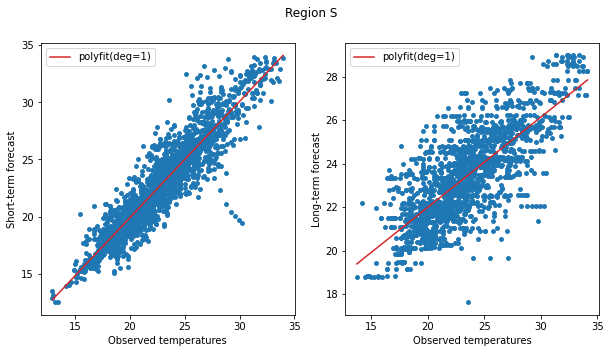

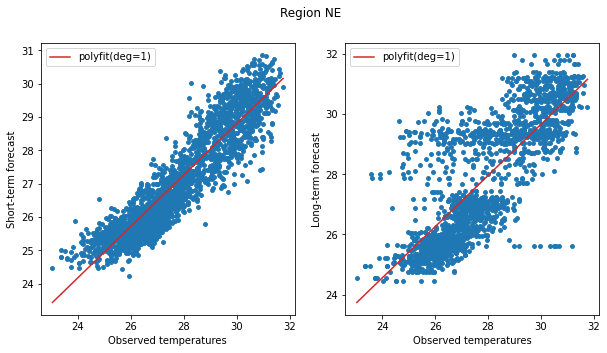

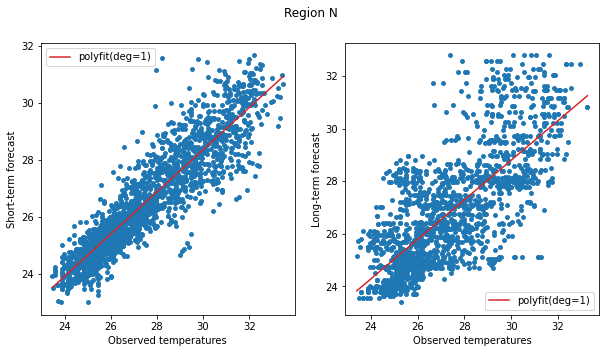

In [76]:
region = "";
OLS_coefs_st = [];
OLS_coefs_lt = [];
regions = [];
remove_outliers = True;


for col in shifted_df.iloc[:,0:9].columns[range(1,9,2)]:
    
    region=(col[col.find("_")+1:])
    sub_df = shifted_df[{"From","obs_"+region,"short_term_"+region,"short_term_shift_"+region,\
                       "long_term_"+region,"long_term_shift_"+region}]
    
    # Thresholds to remove outliers from short-term forecast
    cond_st = (sub_df["obs_"+region]!=0) & (sub_df["short_term_"+region]!=0) & (sub_df["short_term_shift_"+region]!=0)
    p25_st = np.percentile(sub_df.loc[cond_st]["short_term_shift_"+region],25)
    p75_st = np.percentile(sub_df.loc[cond_st]["short_term_shift_"+region],75)
    iqr_st = p75_st-p25_st
    upper_threshold_st = p75_st+1.5*iqr_st
    lower_threshold_st = p25_st-1.5*iqr_st
    
    # Thresholds to remove outliers from long-term forecast
    cond_lt = (sub_df["obs_"+region]!=0) & (sub_df["long_term_"+region]!=0) & (sub_df["long_term_shift_"+region]!=0)
    p25_lt = np.percentile(sub_df.loc[cond_lt]["long_term_shift_"+region],25)
    p75_lt = np.percentile(sub_df.loc[cond_lt]["long_term_shift_"+region],75)
    iqr_lt = p75_lt-p25_lt
    upper_threshold_lt = p75_lt+1.5*iqr_lt
    lower_threshold_lt = p25_lt-1.5*iqr_lt
    
    # Default mask includes outliers
    mask_st = (sub_df["obs_"+region]!=0) & (sub_df["short_term_"+region]!=0) & \
               (sub_df["short_term_shift_"+region]!=0) 
    mask_lt = (sub_df["obs_"+region]!=0) & (sub_df["long_term_"+region]!=0) & \
               (sub_df["long_term_shift_"+region]!=0) 
    
    if remove_outliers == True:
        mask_st = (sub_df["obs_"+region]!=0) & (sub_df["short_term_"+region]!=0) & \
                    (sub_df["short_term_shift_"+region]!=0) & (sub_df["short_term_shift_"+region]>lower_threshold_st) & \
                    (sub_df["short_term_shift_"+region]<upper_threshold_st)
        mask_lt = (sub_df["obs_"+region]!=0) & (sub_df["long_term_"+region]!=0) & \
                    (sub_df["long_term_shift_"+region]!=0) & (sub_df["long_term_shift_"+region]>lower_threshold_lt) & \
                    (sub_df["long_term_shift_"+region]<upper_threshold_lt)
    
    x_st = sub_df[mask_st]["obs_"+region]
    y_st = sub_df[mask_st]["short_term_shift_"+region]
    x_lt = sub_df[mask_lt]["obs_"+region]
    y_lt = sub_df[mask_lt]["long_term_shift_"+region]
    
    coefs_st = np.polyfit(x_st,y_st,1)
    coefs_lt = np.polyfit(x_lt,y_lt,1)

    regions.append(region)
    OLS_coefs_st.append(coefs_st)
    OLS_coefs_lt.append(coefs_lt)
    
    # Plot results
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    fig.suptitle("Region "+region)
    axes[0].scatter(x_st,y_st,s=15)
    x_values_st = np.linspace(x_st.min(),x_st.max(),num=100)
    y_values_st = np.polyval(coefs_st,x_values_st)
    axes[0].plot(x_values_st, y_values_st, c='C3', label='polyfit(deg=1)')
    axes[0].set_xlabel('Observed temperatures')
    axes[0].set_ylabel('Short-term forecast')
    axes[0].legend()
    axes[1].scatter(x_lt,y_lt,s=15)
    x_values_lt = np.linspace(x_lt.min(),x_lt.max(),num=100)
    y_values_lt = np.polyval(coefs_lt,x_values_lt)
    axes[1].plot(x_values_lt, y_values_lt, c='C3', label='polyfit(deg=1)')
    axes[1].set_xlabel('Observed temperatures')
    axes[1].set_ylabel('Long-term forecast')
    axes[1].legend()

Save coefficients of linear regression as a dataframe:

In [77]:
calculated_coefs = pd.DataFrame({"region":regions,"coef_a_st":np.array(OLS_coefs_st)[:,0],"coef_b_st":np.array(OLS_coefs_st)[:,1],\
             "coef_a_lt":np.array(OLS_coefs_lt)[:,0],"coef_b_lt":np.array(OLS_coefs_lt)[:,1]})
calculated_coefs

,region,coef_a_st,coef_b_st,coef_a_lt,coef_b_lt
0,SECO,0.837292,2.977927,0.587138,8.526268
1,S,1.015578,-0.388247,0.414484,13.704208
2,NE,0.771688,5.657522,0.852517,4.093411
3,N,0.737896,6.222216,0.753298,6.203302


For one region, investigate which influence forecast correction brings to data:

In [78]:
test = df[{"From","obs_S","long_term_S"}]
mask = (test["obs_S"]!=0) & (test["long_term_S"]!=0)
test = test[mask]
test["corrected_long_term"] = (test["long_term_S"]-13.704208)/0.414484
test.describe()

,obs_S,long_term_S,corrected_long_term
count,1764.000000,1764.000000,1764.000000
mean,23.295646,23.351235,23.274788
std,3.824805,2.148391,5.183290
min,13.718000,16.392775,6.486541
25%,20.494000,21.808183,19.551960
50%,22.905000,23.192515,22.891854
75%,25.745000,24.744014,26.635059
max,34.126000,29.239895,37.481994


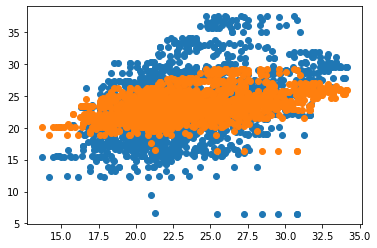

In [79]:
plt.scatter(test["obs_S"],test["corrected_long_term"])
plt.scatter(test["obs_S"],test["long_term_S"])
plt.show()

Compute Pearson correlation coefficient:

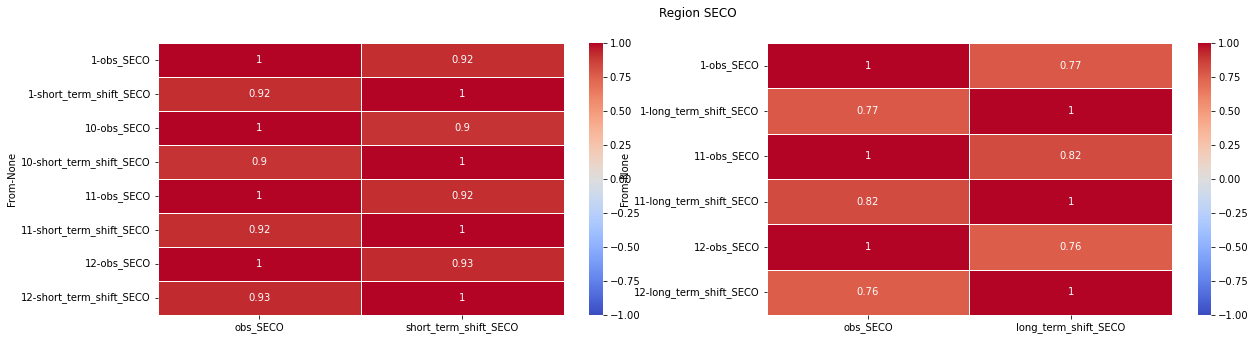

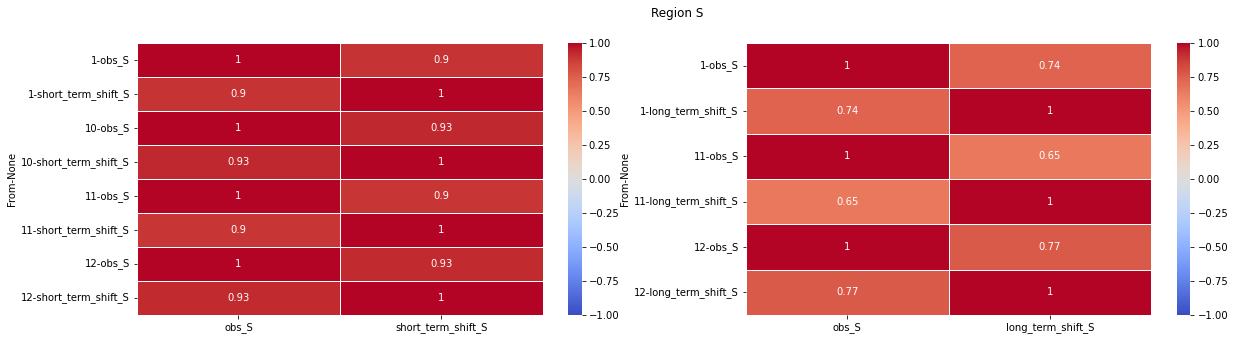

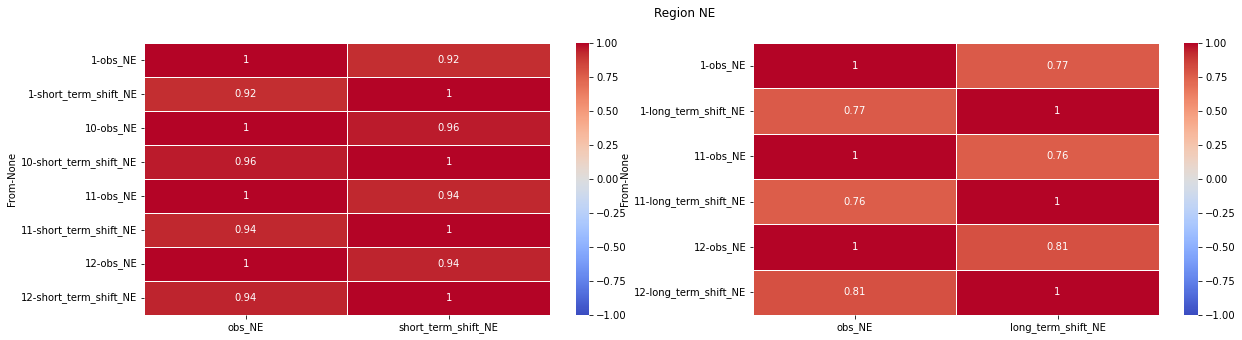

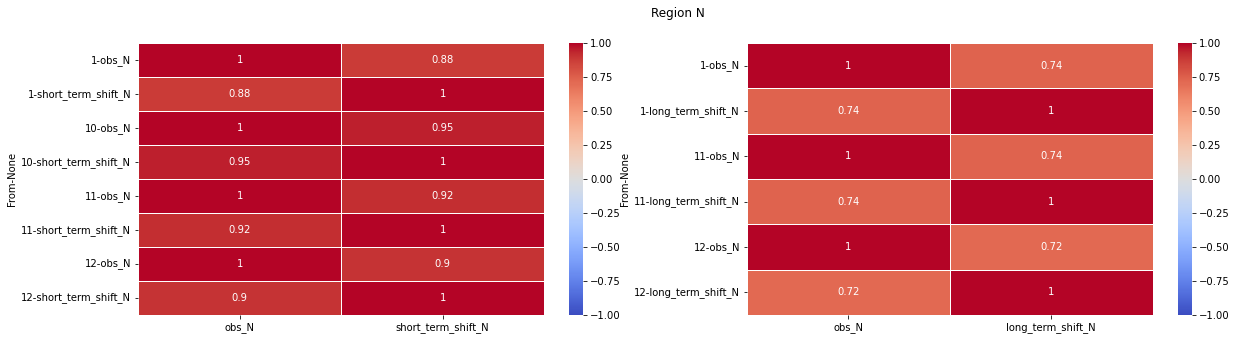

In [80]:
region = "";
remove_outliers = True;


for col in shifted_df.iloc[:,0:9].columns[range(1,9,2)]:
    
    region=(col[col.find("_")+1:])
    sub_df = shifted_df[{"From","obs_"+region,"short_term_"+region,"short_term_shift_"+region,\
                       "long_term_"+region,"long_term_shift_"+region}]
    
    # Thresholds to remove outliers from short-term forecast
    cond_st = (sub_df["obs_"+region]!=0) & (sub_df["short_term_"+region]!=0) & (sub_df["short_term_shift_"+region]!=0)
    p25_st = np.percentile(sub_df.loc[cond_st]["short_term_shift_"+region],25)
    p75_st = np.percentile(sub_df.loc[cond_st]["short_term_shift_"+region],75)
    iqr_st = p75_st-p25_st
    upper_threshold_st = p75_st+1.5*iqr_st
    lower_threshold_st = p25_st-1.5*iqr_st
    
    # Thresholds to remove outliers from long-term forecast
    cond_lt = (sub_df["obs_"+region]!=0) & (sub_df["long_term_"+region]!=0) & (sub_df["long_term_shift_"+region]!=0)
    p25_lt = np.percentile(sub_df.loc[cond_lt]["long_term_shift_"+region],25)
    p75_lt = np.percentile(sub_df.loc[cond_lt]["long_term_shift_"+region],75)
    iqr_lt = p75_lt-p25_lt
    upper_threshold_lt = p75_lt+1.5*iqr_lt
    lower_threshold_lt = p25_lt-1.5*iqr_lt
    
    # Default mask includes outliers
    mask_st = (sub_df["obs_"+region]!=0) & (sub_df["short_term_"+region]!=0) & \
               (sub_df["short_term_shift_"+region]!=0) 
    mask_lt = (sub_df["obs_"+region]!=0) & (sub_df["long_term_"+region]!=0) & \
               (sub_df["long_term_shift_"+region]!=0) 
    
    if remove_outliers == True:
        mask_st = (sub_df["obs_"+region]!=0) & (sub_df["short_term_"+region]!=0) & \
                    (sub_df["short_term_shift_"+region]!=0) & (sub_df["short_term_shift_"+region]>lower_threshold_st) & \
                    (sub_df["short_term_shift_"+region]<upper_threshold_st)
        mask_lt = (sub_df["obs_"+region]!=0) & (sub_df["long_term_"+region]!=0) & \
                    (sub_df["long_term_shift_"+region]!=0) & (sub_df["long_term_shift_"+region]>lower_threshold_lt) & \
                    (sub_df["long_term_shift_"+region]<upper_threshold_lt)
    
    dfcorr_st = pd.concat([sub_df[mask_st]["From"],sub_df[mask_st]["obs_"+region],sub_df[mask_st]["short_term_shift_"+region]],axis=1)
    dfcorr_lt = pd.concat([sub_df[mask_lt]["From"],sub_df[mask_lt]["obs_"+region],sub_df[mask_lt]["long_term_shift_"+region]],axis=1)
    
    # Plot results
    fig, axes = plt.subplots(1,2,figsize=(20,5))
    fig.suptitle("Region "+region)
    sns.heatmap(dfcorr_st.groupby(dfcorr_st["From"].dt.month).corr(),vmin=-1, vmax=1, cmap="coolwarm", annot=True, linewidths=.5, ax=axes[0])
    sns.heatmap(dfcorr_lt.groupby(dfcorr_lt["From"].dt.month).corr(),vmin=-1, vmax=1, cmap="coolwarm", annot=True, linewidths=.5, ax=axes[1])